# Integrated Simulations

In [1]:
import os; from os import listdir; from os.path import isfile, join
import re  
from skimage.io import imread
from skimage.exposure import rescale_intensity
import numpy as np 
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
import seaborn as sns
import rsnapsim as rss
import scipy.stats as stats
import matplotlib.pyplot as plt 

In [2]:
plt.style.use("dark_background")

In [3]:
# Defining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')
masks_dir = current_dir.parents[1].joinpath('DataBases','masks_for_sim_cell')

In [4]:
# Importing rSNAPed
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [5]:
rsp.Banner().print_banner()

 
  ██████╗░░██████╗███╗░░██╗░█████╗░██████╗░███████╗██████╗░ 
  ██╔══██╗██╔════╝████╗░██║██╔══██╗██╔══██╗██╔════╝██╔══██╗ 
  ██████╔╝╚█████╗░██╔██╗██║███████║██████╔╝█████╗░░██║░░██║ 
  ██╔══██╗░╚═══██╗██║╚████║██╔══██║██╔═══╝░██╔══╝░░██║░░██║ 
  ██║░░██║██████╔╝██║░╚███║██║░░██║██║░░░░░███████╗██████╔╝ 
             by : L. Aguilera, T. Stasevich, and B. Munsky 


In [6]:
# These are the parameters that need to be tested. 
number_of_simulated_cells =1     # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 40           # PLEASE TEST MIN 5 MAX 200
simulation_time_in_sec = 30          # PLEASE TEST MIN 10 MAX 100
diffusion_coefficient = 1          # PLEASE TEST MIN 0.1 MAX 2
min_percentage_time_tracking = 0.3   # (normalized) minimum time to consider a trajectory.
average_cell_diameter = 400

In [7]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization

selected_channel_tracking = 0
selected_channel_segmentation = 1

frame_selection_empty_video = 'gaussian' # Options are: 'constant' , 'shuffle' and 'loop' 'linear_interpolation', 'gaussian', 'poisson'
dataframe_format = 'long' # 'short'  'long'

store_videos_in_memory = False
save_as_gif = False 
show_plot = False  # Flag to show plots for the detection and tracking process.


In [8]:
spot_size = 5 # spot size for the simulation and tracking.
spot_sigma = 2
elongation_rate = 20
initiation_rate = 0.01
simulated_RNA_intensities_method = 'random'

In [9]:
basal_intensity_in_background_video = 50000
scale_intensity_in_base_video=False

In [10]:
intensity_scale_ch0 = 2
intensity_scale_ch1 = 2
intensity_scale_ch2 = None

In [11]:
particle_detection_size = spot_size

## Running the simulations

In [12]:
list_videos, list_dataframe_simulated_cell, merged_dataframe_simulated_cells, ssa_trajectories, list_files_names, video_path, dataframe_path = rsp.simulate_cell( video_dir, 
                                                                        list_gene_sequences = gene_file,
                                                                        list_number_spots= number_spots_per_cell,
                                                                        list_target_channels_proteins = 1,
                                                                        list_target_channels_mRNA = 0, 
                                                                        list_diffusion_coefficients=diffusion_coefficient,
                                                                        list_elongation_rates=elongation_rate,
                                                                        list_initiation_rates=initiation_rate,
                                                                        masks_dir=masks_dir, 
                                                                        list_label_names=1,
                                                                        number_cells = number_of_simulated_cells,
                                                                        simulation_time_in_sec = simulation_time_in_sec,
                                                                        step_size_in_sec = 1,
                                                                        save_as_gif = save_as_gif,
                                                                        frame_selection_empty_video=frame_selection_empty_video,
                                                                        spot_size = spot_size,
                                                                        spot_sigma = spot_sigma,
                                                                        intensity_scale_ch0 = intensity_scale_ch0,
                                                                        intensity_scale_ch1 = intensity_scale_ch1,
                                                                        intensity_scale_ch2 = intensity_scale_ch2,
                                                                        dataframe_format = 'long',
                                                                        simulated_RNA_intensities_method=simulated_RNA_intensities_method,
                                                                        store_videos_in_memory= store_videos_in_memory,
                                                                        scale_intensity_in_base_video=scale_intensity_in_base_video,
                                                                        basal_intensity_in_background_video=basal_intensity_in_background_video)

The simulation dataframes are stored here: /home/luisub/Desktop/rsnaped/notebooks/Simulated_Cell/temp_simulation/bg_gaussian_rna_random_ke_20_ki_0_01_kd_1_spots_40_time_30_cells_1_int0_2_int1_2_int2_None/dataframe_bg_gaussian_rna_random_ke_20_ki_0_01_kd_1_spots_40_time_30_cells_1_int0_2_int1_2_int2_None
Time to generate simulated data: 16  sec


In [13]:
number_images = len(list_videos)

In [14]:
# # Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(video_path) if isfile(join(video_path, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_path.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
path_files.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order

# # Reading the microscopy data
number_images = number_of_simulated_cells
number_images

1

# Display simulations for single time point

## <span style="color:red">Channel 0</span>

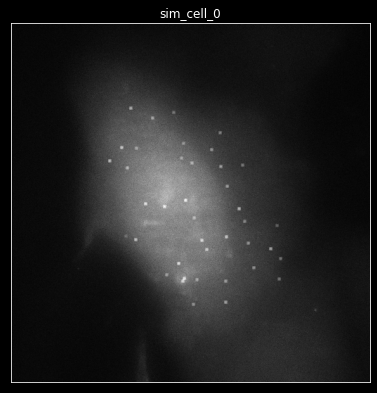

In [15]:
# Showing the simulated images
list_videos = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =0,selected_time_point= 0,normalize=0,individual_figure_size=7).plot()

## <span style="color:lightgreen">Channel 1</span>

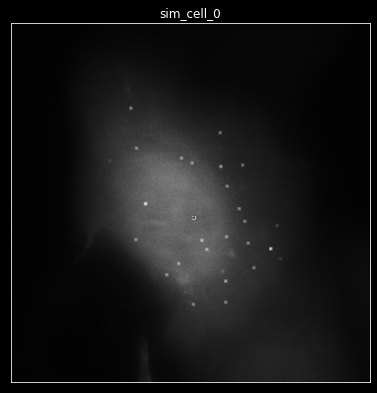

In [16]:
# Showing the simulated images
rsp.VisualizerImage(list_videos,list_files_names=list_files_names,selected_channel =1,selected_time_point= 0,normalize=0,individual_figure_size=7).plot()
del list_videos

In [17]:
list_DataFrame_particles_intensities, list_array_intensities, list_time_vector, list_selected_mask = rsp.image_processing( files_dir_path_processing=video_path,
                                                                                                                            particle_size=particle_detection_size,
                                                                                                                            selected_channel_tracking = selected_channel_tracking,
                                                                                                                            selected_channel_segmentation = selected_channel_segmentation,
                                                                                                                            intensity_calculation_method =intensity_calculation_method, 
                                                                                                                            mask_selection_method = mask_selection_method,
                                                                                                                            show_plot=show_plot,
                                                                                                                            use_optimization_for_tracking=use_optimization_for_tracking,
                                                                                                                            real_positions_dataframe = list_dataframe_simulated_cell,
                                                                                                                            average_cell_diameter=average_cell_diameter,
                                                                                                                            print_process_times=False,
                                                                                                                            min_percentage_time_tracking=min_percentage_time_tracking,
                                                                                                                            dataframe_format=dataframe_format)

The number of detected trajectories is:  45
The selected intensity threshold is:  455.0 

Progress:  1 / 1
Time to process data: 16  sec


# Dataframe

In [18]:
list_DataFrame_particles_intensities[0].head()

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,SNR_red,SNR_green,SNR_blue,background_int_mean_red,background_int_mean_green,background_int_mean_blue,background_int_std_red,background_int_std_green,background_int_std_blue
0,0,0,0,1434.48,13693.66,0.0,812.55,8519.19,0.0,169,122,3.29,3.32,0.0,2359.18,10749.27,0.0,396.73,3835.54,0.0
1,0,0,1,894.60,14916.42,0.0,539.58,8546.83,0.0,168,120,3.17,3.38,0.0,2282.75,10695.48,0.0,268.97,4096.43,0.0
2,0,0,2,1102.00,18335.34,0.0,358.90,5242.34,0.0,167,119,7.54,16.89,0.0,2201.61,9103.43,0.0,149.09,1076.89,0.0
3,0,0,3,1123.96,14766.30,0.0,687.51,8860.91,0.0,167,118,3.16,3.19,0.0,2281.11,10511.18,0.0,328.53,4259.58,0.0
4,0,0,4,987.02,15293.38,0.0,591.32,8988.26,0.0,166,120,3.24,3.44,0.0,2261.48,10553.18,0.0,291.92,4104.00,0.0


# Comparing intensity distributions

## Intensities from SSA

In [19]:
selected_time_point = 0 #simulation_time_in_sec-1

In [20]:
def remove_extrema(vector ,max_percentile = 98):
    '''This function is intended to remove extrema data given by the max percentiles specified by the user'''
    vector = vector [vector>0]
    max_val = np.percentile(vector, max_percentile)
    new_vector = vector [vector< max_val] # = np.percentile(vector,max_percentile)
    print(0 ,round(max_val,2))
    return new_vector

In [21]:
ssa_trajectories_timePoint = ssa_trajectories[:,:,:,:].flatten()
#ssa_trajectories_timePoint = ssa_trajectories[:,:,:,selected_time_point].flatten()
ssa_trajectories_timePoint_normalized = (ssa_trajectories_timePoint-np.amin(ssa_trajectories_timePoint))/ (np.amax(ssa_trajectories_timePoint)-np.amin(ssa_trajectories_timePoint))

In [22]:
def extract_intensity_from_dataframe(dataframe_path=None, dataframe_name=None,selected_time=0,selected_field='green_int_mean', remove_negative_values=True,remove_extreme_values=True):
    list_with_extracted_data = []
    if not(dataframe_path is None):
        temporal_dataframe = pd.read_csv(dataframe_path)
    else:
        temporal_dataframe = dataframe_name
    extracted_data = temporal_dataframe.loc[(temporal_dataframe['frame']==selected_time)][selected_field].values
    # Negative values may appear if the intensity in the background is higher than the intensity in the spot. This option allows to remove negative values.
    #if remove_negative_values == True:
    #    extracted_data =  extracted_data[extracted_data>=0] 
    # To plot the histogram, we could remove extreme values. Extreme values are defined as those above the 98 percentile. 
    #if remove_extreme_values==True:
    #    extracted_data= remove_extrema(extracted_data)  
    # Option to normalize data to the maximum value.
    normalized_extracted_data = (extracted_data-np.min(extracted_data))/ (np.max(extracted_data)-np.min(extracted_data))  
    return extracted_data,normalized_extracted_data

## Recovered intensities from tracking

In [23]:
# list_DataFrame_particles_intensities
DataFrame_particles_intensities_tracking_merged = pd.concat(list_DataFrame_particles_intensities)
intensities_tracking,intensities_tracking_normalized =  extract_intensity_from_dataframe(dataframe_name=DataFrame_particles_intensities_tracking_merged,selected_time=0,selected_field='green_int_mean')


## Loading intensities from image. "Perfect tracking"

In [24]:
dataframe_path

PosixPath('/home/luisub/Desktop/rsnaped/notebooks/Simulated_Cell/temp_simulation/bg_gaussian_rna_random_ke_20_ki_0_01_kd_1_spots_40_time_30_cells_1_int0_2_int1_2_int2_None/dataframe_bg_gaussian_rna_random_ke_20_ki_0_01_kd_1_spots_40_time_30_cells_1_int0_2_int1_2_int2_None/dataframe_sim_cell.csv')

In [25]:
intensity_values_in_image_flat,intensity_values_in_image_normalized =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='green_int_mean')

# Intensity histograms with au

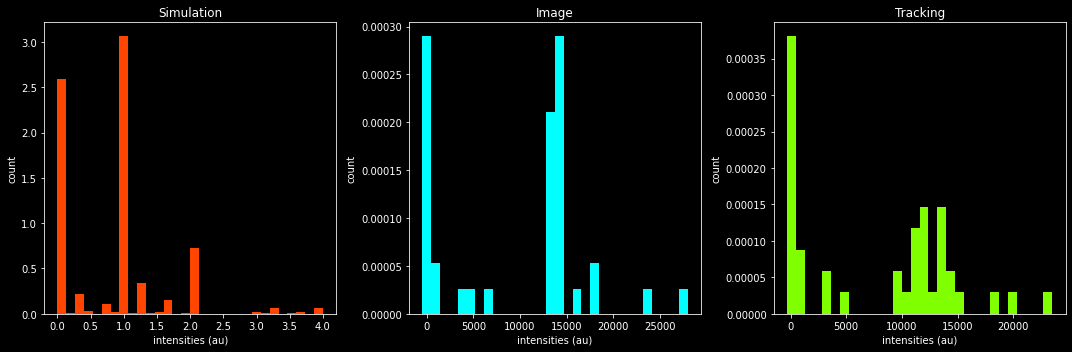

In [26]:
# plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].hist(ssa_trajectories_timePoint,bins=30,density=True, stacked=True, color='orangered' )     
axes[0].set(title='Simulation')
axes[0].set(xlabel='intensities (au)')
axes[0].set(ylabel='count')

axes[1].hist(intensity_values_in_image_flat,bins=30,density=True, stacked=True, color='cyan' )     
axes[1].set(title='Image')
axes[1].set(xlabel='intensities (au)')
axes[1].set(ylabel='count')

axes[2].hist(intensities_tracking,bins=30,density=True, stacked=True, color='chartreuse' )     
axes[2].set(title='Tracking')
axes[2].set(xlabel='intensities (au)')
axes[2].set(ylabel='count')
plt.tight_layout()

## Normalizing intensities to 1.

$ X_{norm} = \frac{X -min(X)}{max(X) - min(X)} $

In [27]:
def histogram_fit(data,normalize_range=True):
    
    # Option to normalize data to the maximum value.
    #if normalize_range == True:
    data = (data-np.min(data))/ (np.max(data)-np.min(data))  
    data = np.sort(data)
    
    # Histogram
    hist_values, bins_values = np.histogram(data, bins=20, density=True)
    unity_density = hist_values / hist_values.sum()
    
    bincentres = [(bins_values[i]+bins_values[i+1])/2. for i in range(len(bins_values)-1)]
    # Gaussian fit
    mu, sigma = scipy.stats.norm.fit(data)
    fit_hist = scipy.stats.norm.pdf(bins_values, mu, sigma)
    
    norm_fit_hist = fit_hist / fit_hist.sum()
    
    # Commutative 
    line_space_values =np.linspace(np.min(data), np.max(data), len(data), endpoint=False) 
    
    #return data_sorted, line_space_values
    return bincentres, bins_values, unity_density, norm_fit_hist, data, line_space_values
    

In [28]:
# Data
data1 = ssa_trajectories_timePoint_normalized
data2 = intensities_tracking_normalized
data3 = intensity_values_in_image_normalized
bincentres1, bins_values1, hist_values1, fit_hist1, data_sorted1, linspace1 = histogram_fit(data1,normalize_range=True)
bincentres2, bins_values2, hist_values2, fit_hist2, data_sorted2, linspace2 = histogram_fit(data2,normalize_range=True)
bincentres3, bins_values3, hist_values3, fit_hist3, data_sorted3, linspace3 = histogram_fit(data3,normalize_range=True)

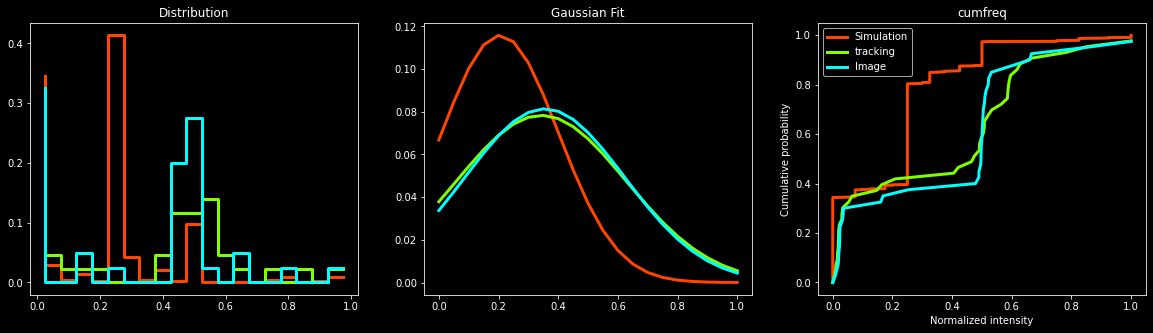

Number of spots for Simulation: 1200
Number of spots recovered from tracking: 43
Number of spots recovered from image: 40


In [29]:
# Plotting
plt.style.use("dark_background")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

# Plotting Histograms
axes[0].step(bincentres1, hist_values1, 'orangered',linewidth=3,label ='Simulation')
axes[0].step(bincentres2, hist_values2,'chartreuse',linewidth=3,label ='tracking')
axes[0].step(bincentres3, hist_values3,'cyan',linewidth=3,label ='Image')

# Plotting Fits
axes[1].plot(bins_values1, fit_hist1, 'orangered',linewidth=3,label ='Simulation')
axes[1].plot(bins_values2, fit_hist2,'chartreuse',linewidth=3,label ='tracking')
axes[1].plot(bins_values3, fit_hist3,'cyan',linewidth=3,label ='Image')

# Plotting cumulative
axes[2].plot(data_sorted1, linspace1, 'orangered',linewidth=3,label ='Simulation')
axes[2].plot(data_sorted2, linspace2, 'chartreuse',linewidth=3,label ='tracking')
axes[2].plot(data_sorted3, linspace3, 'cyan',linewidth=3,label ='Image')

axes[0].set(title='Distribution')
axes[1].set(title='Gaussian Fit')
axes[2].set(title='Cumulative')

axes[0].grid(False)
axes[1].grid(False)
axes[2].grid(False)

plt.legend()
plt.title('cumfreq')
plt.ylabel('Cumulative probability')
plt.xlabel('Normalized intensity')
plt.show()

# Print number of spots
print('Number of spots for Simulation:',len(data1))
print('Number of spots recovered from tracking:',len(data2))
print('Number of spots recovered from image:',len(data3))

### Statisics from normalized distributions

In [30]:
print('mean ssa:              ', np.round(np.mean(ssa_trajectories_timePoint_normalized),3) )
print('mean perfect tracking: ', np.round(np.mean(intensity_values_in_image_normalized),3)  )
print('mean tracking:         ', np.round(np.mean(intensities_tracking_normalized),3)  )

mean ssa:               0.205
mean perfect tracking:  0.355
mean tracking:          0.343


In [31]:
print('std ssa:              ', np.round(np.std(ssa_trajectories_timePoint_normalized),3) )
print('std perfect tracking: ', np.round(np.std(intensity_values_in_image_normalized),3)  )
print('std tracking:         ', np.round(np.std(intensities_tracking_normalized),3)  )

std ssa:               0.195
std perfect tracking:  0.267
std tracking:          0.285


## Cummulative frequencies

## Comparison using the KS-distance

In [32]:
# Calculating Kolmogorov distance

ks_distance = scipy.stats.kstest(data1,data2).statistic
print('The KS-distance between SSA and tracking is:' , round(ks_distance,2))

ks_distance = scipy.stats.kstest(data1,data3).statistic
print('The KS-distance between SSA and image is:' , round(ks_distance,2))

#ks_distance = scipy.stats.kstest(data3,data2).statistic
#print('The KS-distance between image and tracking is:' , round(ks_distance,2))

The KS-distance between SSA and tracking is: 0.41
The KS-distance between SSA and image is: 0.48


## Comparison using the Anderson-Darling distance


In [33]:
ad_distance,_,_ = scipy.stats.anderson_ksamp([data1,data2],midrank=False)
print('The AD-distance between SSA and tracking is:' , round(ad_distance,2))

ad_distance,_,_ = scipy.stats.anderson_ksamp([data1,data3],midrank=False)
print('The AD-distance between SSA and image is:' , round(ad_distance,2))

The AD-distance between SSA and tracking is: 48.94
The AD-distance between SSA and image is: 54.04


#
## Comparison using likelihood function
#

In [34]:
def LL_fun(real_data,simulation_data,nbins=30):
    hist_exp_data, hist_exp_bins = np.histogram( real_data , bins=nbins)
    dist_sim_data, dist_sim_bins = np.histogram(simulation_data, bins=hist_exp_bins, density=True)
    dist_sim_data[dist_sim_data ==0] = 1e-7
    LL_int_distb = np.dot(hist_exp_data,np.log(dist_sim_data))    # likelihood function for comparing distributions
    return LL_int_distb


In [35]:
## LOG LIKELIHOOD OF THE INTENSITY DISTRIBUTIONS

LL_ssa_tracking = LL_fun(real_data= data_sorted1,simulation_data=data_sorted2,nbins=100)
print('The Likelihood between SSA and tracking is:' , round(LL_ssa_tracking,2))

LL_ssa_img = LL_fun(real_data=data_sorted1, simulation_data=data_sorted3,nbins=100)
print('The Likelihood between SSA and image is:' , round(LL_ssa_img,2))

The Likelihood between SSA and tracking is: -9058.25
The Likelihood between SSA and image is: -1213.86


# Scatter Plots

In [36]:
def plot_scatter_spots_cell_size(x,y,plot_title,selected_color = '#1C00FE',xlabel='',ylabel=''):
    r, p = stats.pearsonr(x, y)
    df_join_distribution = pd.DataFrame({'X':x,'Y':y})
    #plt.figure(figsize=(6,5))
    sns.set(font_scale = 1.3)
    b = sns.jointplot(data=df_join_distribution, y='Y', x='X', color= selected_color , marginal_kws=dict(bins=40, rug=True))
    b.plot_joint(sns.rugplot, height=0, color=[0.7,0.7,0.7], clip_on=True)
    b.plot_joint(sns.kdeplot, color=[0.5,0.5,0.5], levels=5)
    b.plot_joint(sns.regplot,scatter_kws={'color': 'orangered',"s":10, 'marker':'o'}, line_kws={'color': selected_color,'lw': 2} )
    blank_plot, = b.ax_joint.plot([], [], linestyle="", alpha=0)
    b.ax_joint.legend([blank_plot],['r={:.2f}'.format( np.round(r,2))],loc='upper left',)
    b.ax_joint.set_xlim(np.percentile(x,1), np.percentile(x,99))
    b.ax_joint.set_ylim(np.percentile(y,1), np.percentile(y,99))
    b.fig.suptitle(plot_title)
    b.ax_joint.set_xlabel(xlabel)
    b.ax_joint.set_ylabel(ylabel)
    b.ax_joint.collections[0].set_alpha(0)
    b.fig.tight_layout()
    b.fig.subplots_adjust(top=0.92) 
    #name_plot = plot_title +'.pdf'  
    #plt.savefig(name_plot, transparent=False,dpi=1200, bbox_inches = 'tight', format='pdf')
    plt.show()
    #pathlib.Path().absolute().joinpath(name_plot).rename(pathlib.Path().absolute().joinpath(destination_folder,name_plot))
    return

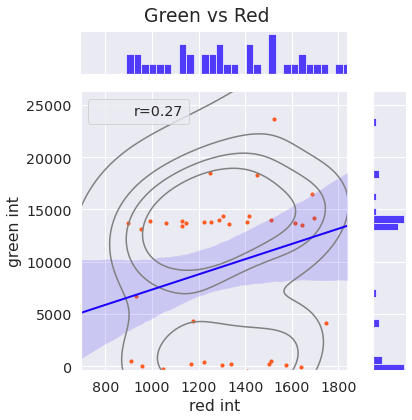

In [37]:
# Scatter plots intensity comparing all channels
#red_int_mean	green_int_mean	blue_int_mean	red_int_std	green_int_std	blue_int_std	x	y	SNR_red	SNR_green	SNR_blue	background_int_mean_red	background_int_mean_green	background_int_mean_blue	background_int_std_red	background_int_std_green	background_int_std_blue
int_red,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
int_green,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(int_red,int_green,plot_title='Green vs Red',selected_color = '#1C00FE',xlabel='red int',ylabel='green int')

## <span style="color:lightgreen">Channel 1</span>

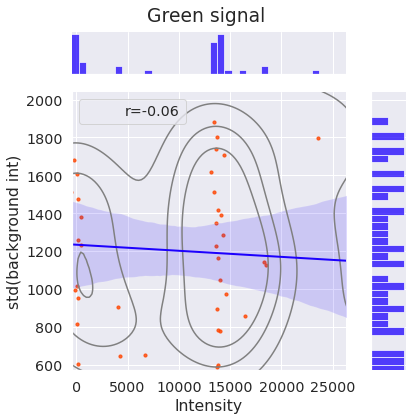

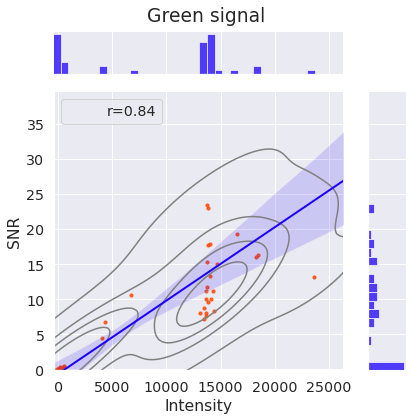

In [38]:
# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
background,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='background_int_std_green', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,background,plot_title='Green signal',selected_color = '#1C00FE',ylabel='std(background int)',xlabel='Intensity')

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
SNR,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='SNR_green', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='green_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,SNR,plot_title='Green signal',selected_color = '#1C00FE',xlabel='Intensity',ylabel='SNR')

## <span style="color:red">Channel 0</span>

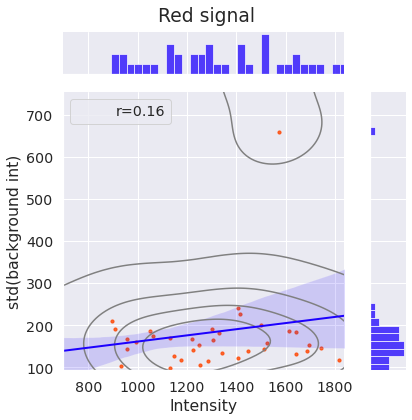

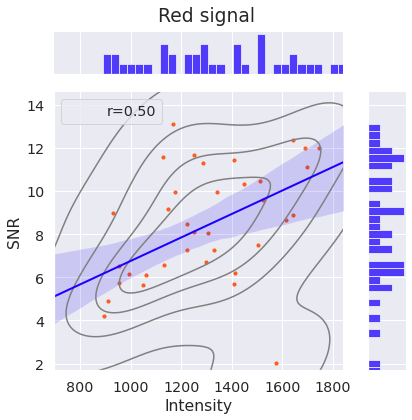

In [39]:

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
background,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='background_int_std_red', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,background,plot_title='Red signal',selected_color = '#1C00FE',ylabel='std(background int)',xlabel='Intensity')

# Scatter plots intensity comparing all channels # background_int_std_green #SNR_green
SNR,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='SNR_red', remove_negative_values=False,remove_extreme_values=False)
intensity,_ =  extract_intensity_from_dataframe(dataframe_path=dataframe_path,selected_time=0,selected_field='red_int_mean', remove_negative_values=False,remove_extreme_values=False)
plot_scatter_spots_cell_size(intensity,SNR,plot_title='Red signal',selected_color = '#1C00FE',xlabel='Intensity',ylabel='SNR')